# **Final Project**
## *Khushi Gandhi*
#### **USC ID:** *kjgandhi@usc.edu*
#### **GitHUB ID:** *kkhushig*

*Mounting Google Drive for the dataset.*

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


*Importing all the necessary libraries.*

In [2]:
import os
import os.path as op
import json
from pathlib import Path
import shutil
import logging
import numpy as np
from tqdm import tqdm
from skimage import io
import matplotlib.pyplot as plt
import zipfile
import random
import tensorflow as tf
from PIL import Image
from sklearn.metrics import classification_report

from tensorflow.keras import regularizers, layers, models
from tensorflow.keras.applications import EfficientNetB0, ResNet50, VGG16
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, BatchNormalization, Dropout
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# 1. Identification of Frost in Martian HiRISE Images

(a) In this problem, we are trying to build a classfier that distinguishes images of Martian terrain with frost. You can find the dataset in https://dataverse.jpl.nasa.gov/dataset.xhtml?persistentId=doi:10.48577/jpl.QJ9PYA.
This dataset was created to study Mars' seasonal frost cycle and its role in the
planet's climate and surface evolution over the past 2 billion years. The data helps in identifying low-latitude frosted microclimates and their impact on climate.

In [3]:
# Logging configuration
logging.basicConfig(level=logging.INFO,
                    datefmt='%H:%M:%S',
                    format='%(asctime)s | %(levelname)-5s | %(module)-15s | %(message)s')

IMAGE_SIZE = (299, 299)  # All images contained in this dataset are 299x299 (originally, to match Inception v3 input size)
SEED = 17

# Head directory containing all image subframes. Update with the relative path of your data directory
data_head_dir = Path('/content/drive/MyDrive/data')

# Find all subframe directories
subdirs = [Path(subdir.stem) for subdir in data_head_dir.iterdir() if subdir.is_dir()]
src_image_ids = ['_'.join(a_path.name.split('_')[:3]) for a_path in subdirs]

In [4]:
# Load train/val/test subframe IDs
def load_text_ids(file_path):
    """Simple helper to load all lines from a text file"""
    with open(file_path, 'r') as f:
        lines = [line.strip() for line in f.readlines()]
    return lines

# Load the subframe names for the three data subsets
train_ids = load_text_ids('/content/drive/MyDrive/data/train_source_images.txt')
validate_ids = load_text_ids('/content/drive/MyDrive/data/val_source_images.txt')
test_ids = load_text_ids('/content/drive/MyDrive/data/test_source_images.txt')

# Generate a list containing the dataset split for the matching subdirectory names
subdir_splits = []
for src_id in src_image_ids:
    if src_id in train_ids:
        subdir_splits.append('train')
    elif src_id in validate_ids:
        subdir_splits.append('validate')
    elif(src_id in test_ids):
        subdir_splits.append('test')
    else:
        logging.warning(f'{src_id}: Did not find designated split in train/validate/test list.')
        subdir_splits.append(None)

# (b) Data Exploration and Pre-processing


i. Images (png files) and labels (json files) are organized in the data directory by \subframes." Subframes are individual 5120x5120 pixel images which are crops of the original HiRISE images (often on the order of 50k x 10k pixels).

Individual subframes were annotated by the contributors and then sliced into
299x299 \tiles." Each tile has an associated label for use in training ML
algorithms.

There are 214 subframes and a total of 119920 tiles. Each tile has annotations
which have been used to assign labels to the tiles `frost' or `background.'
Each JSON file contains all the annotation information collected from human
annotators.

The following are relevant to the assignment:
Image tiles are organized into folders of `background' and `frost' classes (bi-
nary). For the purpose of the final project, individual tiles shall serve as the
data points which need to be classified using binary classification.
ii. The dataset includes files for splitting the data into train, test and validation.

However, you will be provided by an improved version of those files when a
repo is created:

A. train source images.txt

B. test source images.txt

C. val source images.txt

iii. Each of these files contains the IDs of the high rise images (parent folders for the subframes and tiles).

In [5]:
def load_and_preprocess(img_loc, label):

    def _inner_function(img_loc, label):

        # Convert tensor to native type
        img_loc_str = img_loc.numpy().decode('utf-8')
        label_str = label.numpy().decode('utf-8')

        img = Image.open(img_loc_str).convert('RGB')


        return img, 1 if label_str=='frost' else 0

    # Wrap the Python function
    X, y = tf.py_function(_inner_function, [img_loc, label], [tf.float32, tf.int64])

    return X, y

def load_subdir_data(dir_path, image_size, seed=None):

    """Helper to create a TF dataset from each image subdirectory"""

    # Grab only the classes that (1) we want to keep and (2) exist in this directory
    tile_dir = dir_path / Path('tiles')
    label_dir = dir_path /Path('labels')

    loc_list = []

    for folder in os.listdir(tile_dir):
        if os.path.isdir(os.path.join(tile_dir, folder)):
            for file in os.listdir(os.path.join(tile_dir, folder)):
                if file.endswith(".png"):
                    loc_list.append((os.path.join(os.path.join(tile_dir, folder), file), folder))

    return loc_list

# Loop over all subframes, loading each into a list
tf_data_train, tf_data_test, tf_data_val = [], [], []
tf_dataset_train, tf_dataset_test, tf_dataset_val = [], [], []

# Update the batch and buffer size as per your model requirements
buffer_size = 64
batch_size = 32

for subdir, split in zip(subdirs, subdir_splits):
    full_path = data_head_dir / subdir
    if split=='validate':
        tf_data_val.extend(load_subdir_data(full_path, IMAGE_SIZE, SEED))
    elif split=='train':
        tf_data_train.extend(load_subdir_data(full_path, IMAGE_SIZE, SEED))
    elif split=='test':
        tf_data_test.extend(load_subdir_data(full_path, IMAGE_SIZE, SEED))

random.shuffle(tf_data_train)
img_list, label_list = zip(*tf_data_train)
img_list_t = tf.convert_to_tensor(img_list)
lb_list_t = tf.convert_to_tensor(label_list)

tf_dataset_train = tf.data.Dataset.from_tensor_slices((img_list_t, lb_list_t))
tf_dataset_train = tf_dataset_train.map(load_and_preprocess, num_parallel_calls=tf.data.experimental.AUTOTUNE)
tf_dataset_train = tf_dataset_train.shuffle(buffer_size=buffer_size).batch(batch_size)

random.shuffle(tf_data_val)
img_list, label_list = zip(*tf_data_val)
img_list_t = tf.convert_to_tensor(img_list)
lb_list_t = tf.convert_to_tensor(label_list)

tf_dataset_val = tf.data.Dataset.from_tensor_slices((img_list_t, lb_list_t))
tf_dataset_val = tf_dataset_val.map(load_and_preprocess, num_parallel_calls=tf.data.experimental.AUTOTUNE)
tf_dataset_val = tf_dataset_val.shuffle(buffer_size=buffer_size).batch(batch_size)

random.shuffle(tf_data_test)
img_list, label_list = zip(*tf_data_test)
img_list_t = tf.convert_to_tensor(img_list)
lb_list_t = tf.convert_to_tensor(label_list)

tf_dataset_test = tf.data.Dataset.from_tensor_slices((img_list_t, lb_list_t))
tf_dataset_test = tf_dataset_test.map(load_and_preprocess, num_parallel_calls=tf.data.experimental.AUTOTUNE)
tf_dataset_test = tf_dataset_test.shuffle(buffer_size=buffer_size).batch(batch_size)

In [6]:
print(len(tf_dataset_train))

928


# (c) Training CNN + MLP



i. To perform empirical regularization, crop, randomly zoom, rotate, flip, contrast, and translate images in your training set for image augmentation. You can use various tools to do this, including OpenCV.

In [7]:
def augmentation(img, label):
    img = tf.image.random_flip_left_right(img)
    img = tf.image.random_flip_up_down(img)
    img = tf.image.random_contrast(img, lower=0.7, upper=1.2)
    img = tf.image.random_brightness(img, max_delta=0.1)
    img = tf.image.random_hue(img, max_delta=0.1)
    return img, label

In [8]:
def fixshape(images, labels):
    images.set_shape([None, 299, 299, 3])
    labels.set_shape([None, ])
    return images, labels

tf_dataset_train = tf_dataset_train.map(fixshape)
tf_dataset_val = tf_dataset_val.map(fixshape)
tf_dataset_test = tf_dataset_test.map(fixshape)

augTrain = tf_dataset_train.map(augmentation, num_parallel_calls=tf.data.experimental.AUTOTUNE)
augTrain = augTrain.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

In [9]:
print(len(augTrain))

928


ii. Train a three-layer CNN followed by a dense layer on the data. Choose the
size of the kernels and depth of the layers and the number of neurons in
the dense layer (MLP) on your own. Use ReLU's in all of the layers. Use
the softmax function, batch normalization3 and a dropout rate of 30%, L2 regularization, as well as ADAM optimizer. Use cross entropy loss. Train
for at least 20 epochs and perform early stopping using the validation set.
Keep the network parameters that have the lowest validation error. Plot the
training and validation errors vs. epochs

In [10]:
model = models.Sequential()

#Convolutional layers
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(299,  299, 3), kernel_regularizer=regularizers.l2(0.01)))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Conv2D(64, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.01)))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Conv2D(128, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.01)))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D((2, 2)))

#Flatten layer
model.add(layers.Flatten())

#Dense layer with dropout
model.add(layers.Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.01)))
model.add(layers.BatchNormalization())
model.add(layers.Dropout(0.3))

#Output layer
model.add(layers.Dense(2, activation='softmax'))

# Compile the model
model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss=SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

# Early stopping callback
earlyStopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

cnnmlp = model.fit(
    augTrain,
    epochs=20,
    validation_data=tf_dataset_val,
    callbacks=[earlyStopping]
)

Epoch 1/20
928/928 [==============================] - 1936s 2s/step - loss: 1.9042 - accuracy: 0.7685 - val_loss: 6.1250 - val_accuracy: 0.3218
Epoch 2/20
928/928 [==============================] - 148s 159ms/step - loss: 0.9904 - accuracy: 0.8235 - val_loss: 3.0893 - val_accuracy: 0.3218
Epoch 3/20
928/928 [==============================] - 146s 157ms/step - loss: 0.9990 - accuracy: 0.8407 - val_loss: 2.6497 - val_accuracy: 0.3339
Epoch 4/20
928/928 [==============================] - 145s 156ms/step - loss: 0.9893 - accuracy: 0.8528 - val_loss: 1.4941 - val_accuracy: 0.6216
Epoch 5/20
928/928 [==============================] - 143s 153ms/step - loss: 0.8518 - accuracy: 0.8747 - val_loss: 2.4834 - val_accuracy: 0.3678
Epoch 6/20
928/928 [==============================] - 144s 154ms/step - loss: 0.7933 - accuracy: 0.8764 - val_loss: 2.4952 - val_accuracy: 0.3280
Epoch 7/20
928/928 [==============================] - 145s 156ms/step - loss: 0.6988 - accuracy: 0.8881 - val_loss: 3.2594 - v

In [11]:
def alplot(history):

  fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 10))

  # Plotting Loss
  ax1.plot(history.history['loss'], label='Training Loss', color='red')
  ax1.plot(history.history['val_loss'], label='Validation Loss', color='green')
  ax1.set_xlabel('Epochs')
  ax1.set_ylabel('Loss')
  ax1.legend(['Train', 'Validation'], loc='best')

  # Plotting Accuracy
  ax2.plot(history.history['accuracy'], label='Training Accuracy', color='red')
  ax2.plot(history.history['val_accuracy'], label='Validation Accuracy', color='green')
  ax2.set_xlabel('Epochs')
  ax2.set_ylabel('Accuracy')
  ax2.legend(['Train', 'Validation'], loc='best')

  plt.show()


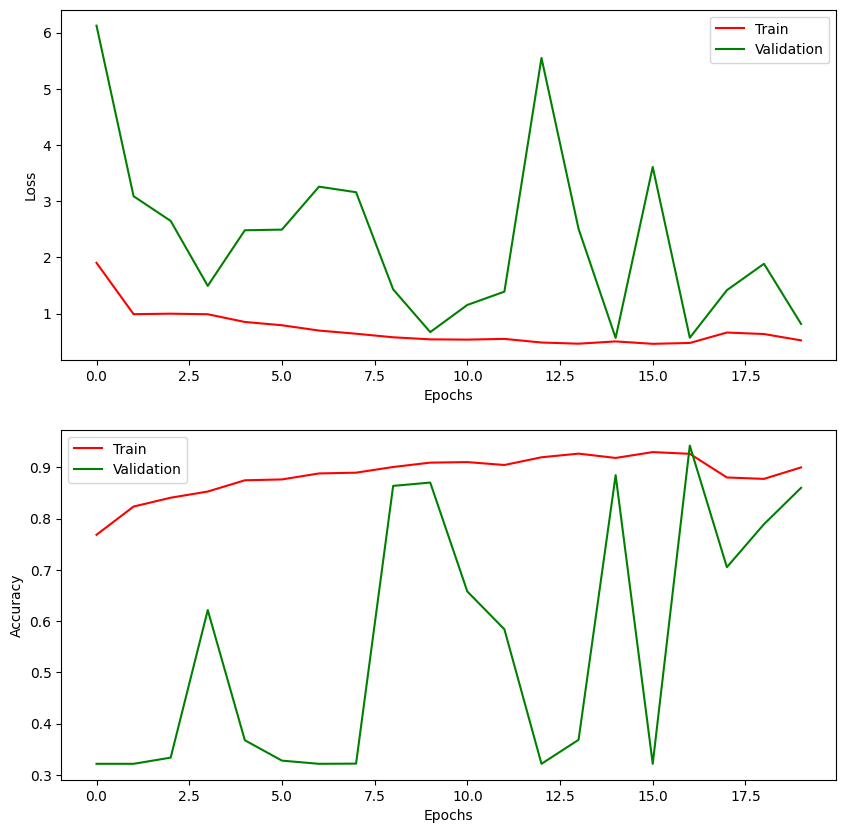

In [13]:
alplot(cnnmlp)

iii. Report Precision, Recall and F1 Score for your model.

In [14]:
def predictor(dataset):
  yPred = model.predict(dataset)
  ycPred = np.argmax(yPred, axis=1)
  yTrueList = [b for a, b in dataset]
  yTrue = np.concatenate(yTrueList, axis=0)
  #yTrue = tf.concat([b for a, b in dataset], axis=0)
  return ycPred, yTrue

ycPredTrain , yTrueTrain = predictor(tf_dataset_train)
ycPredVal, yTrueVal = predictor(tf_dataset_val)
ycPredTest, yTrueTest = predictor(tf_dataset_test)

cmcrtrain = classification_report(yTrueTrain, ycPredTrain)
cmcrval = classification_report(yTrueTest, ycPredTest)
cmcrtest = classification_report(yTrueVal, ycPredVal)

print("Training Classification Report:")
print(cmcrtrain)

print("\nTesting Classification Report:")
print(cmcrval)

print("\nValidation Classification Report:")
print(cmcrtest)

401/401 [==============================] - 543s 1s/step
Training Classification Report:
              precision    recall  f1-score   support

           0       0.42      0.40      0.41     12235
           1       0.59      0.61      0.60     17457

    accuracy                           0.52     29692
   macro avg       0.50      0.50      0.50     29692
weighted avg       0.52      0.52      0.52     29692


Testing Classification Report:
              precision    recall  f1-score   support

           0       0.35      0.32      0.34      4418
           1       0.66      0.69      0.67      8405

    accuracy                           0.56     12823
   macro avg       0.51      0.51      0.50     12823
weighted avg       0.55      0.56      0.56     12823


Validation Classification Report:
              precision    recall  f1-score   support

           0       0.69      0.57      0.62      7654
           1       0.33      0.45      0.38      3632

    accuracy               

# (d) Transfer Learning

i. When dealing with classification of relatively small image datasets, deep networks may not perform very well because of not having enough data to train them. In such cases, one usually uses transfer learning, which uses deep learning models that are trained on very large datasets such as ImageNet as feature extractors. The idea is that such deep networks have learned to extract meaningful features from an image using their layers, and those features can be used in learning other tasks. In order to do that, usually the last layer or the last few layers of the pre-trained network are removed, and the response of the layer before the removed layers to the images in the new dataset is used as a feature vector to train one more multiple replacement
layers. In this project, you will use pre-trained models (EfficientNetB0, ResNet50, and VGG16). For these pre-trained networks, you will only train the last fully connected layer, and will freeze all layers before them (i.e. we
do not change their parameters during training) and use the outputs of the penultimate layer in the original pre-trained model as the features extracted from each image.

ii. To perform empirical regularization, crop, randomly zoom, rotate, flip, contrast, and translate images in your training set for image augmentation. You can use various tools to do this, including OpenCV.

iii. Use ReLU activation functions in the last layer and a softmax layer, along
with batch normalization and a dropout rate of 30% as well as ADAM
optimizer. Use cross entropy loss. You can try any batch size, but a batch
size of 8 seems reasonable.

iv. Train using the features calculated by networks (EfficientNetB0, ResNet50,
and VGG16) for at least 10 epochs (preferably 20 epochs) and perform early
stopping using the validation set. Keep the network parameters that have the
lowest validation error. Plot the training and validation errors vs. epochs.

v. Report Precision, Recall, and F1 score for your model.

In [15]:
#Function to implement all three pre-trained models
def transferlearn(initialmodel):
    initialmodel.trainable = False #Freezes all layers except the last fully connected layer

    model = models.Sequential([
        initialmodel,
        layers.Flatten(),
        layers.Dense(128, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.3),
        layers.Dense(2, activation='softmax')  #2 as binary
    ])

    model.compile(
        optimizer=Adam(learning_rate = 0.001),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )

    return model

earlyStopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

In [16]:
def predicts(model, dataset):
  yPred = model.predict(dataset)
  ycPred = np.argmax(yPred, axis=1)
  yTrueList = [b for a, b in dataset]
  yTrue = np.concatenate(yTrueList, axis=0)
  #yTrue = tf.concat([b for a, b in dataset], axis=0)
  return ycPred, yTrue

def crep(model):
  ycPredTrain , yTrueTrain = predicts(model, tf_dataset_train)
  ycPredVal, yTrueVal = predicts(model, tf_dataset_val)
  ycPredTest, yTrueTest = predicts(model, tf_dataset_test)

  crtrain = classification_report(yTrueTrain, ycPredTrain)
  crval = classification_report(yTrueTest, ycPredTest)
  crtest = classification_report(yTrueVal, ycPredVal)

  print("Training Classification Report:")
  print(crtrain)

  print("\nTesting Classification Report:")
  print(crval)

  print("\nValidation Classification Report:")
  print(crtest)
  return crtrain, crval, crtest

## EfficientNetB0

In [17]:
EN = EfficientNetB0(input_shape=(299, 299, 3), include_top=False, weights='imagenet')
ENmodel = transferlearn(EN)

16705208/16705208 [==============================] - 1s 0us/step


In [18]:
efficientnet = ENmodel.fit(
    augTrain,
    epochs=20,
    validation_data=tf_dataset_val,
    batch_size=8,
    callbacks=[earlyStopping]
)

Epoch 1/20
928/928 [==============================] - 165s 169ms/step - loss: 0.1707 - accuracy: 0.9343 - val_loss: 0.2478 - val_accuracy: 0.9069
Epoch 2/20
928/928 [==============================] - 155s 167ms/step - loss: 0.1010 - accuracy: 0.9628 - val_loss: 0.2254 - val_accuracy: 0.9090
Epoch 3/20
928/928 [==============================] - 154s 166ms/step - loss: 0.0828 - accuracy: 0.9697 - val_loss: 0.1653 - val_accuracy: 0.9343
Epoch 4/20
928/928 [==============================] - 153s 165ms/step - loss: 0.0764 - accuracy: 0.9717 - val_loss: 0.2896 - val_accuracy: 0.8976
Epoch 5/20
928/928 [==============================] - 154s 165ms/step - loss: 0.0675 - accuracy: 0.9750 - val_loss: 0.2939 - val_accuracy: 0.8915
Epoch 6/20
928/928 [==============================] - 153s 165ms/step - loss: 0.0701 - accuracy: 0.9738 - val_loss: 0.2640 - val_accuracy: 0.8923
Epoch 7/20
928/928 [==============================] - 152s 164ms/step - loss: 0.0722 - accuracy: 0.9741 - val_loss: 0.2337 -

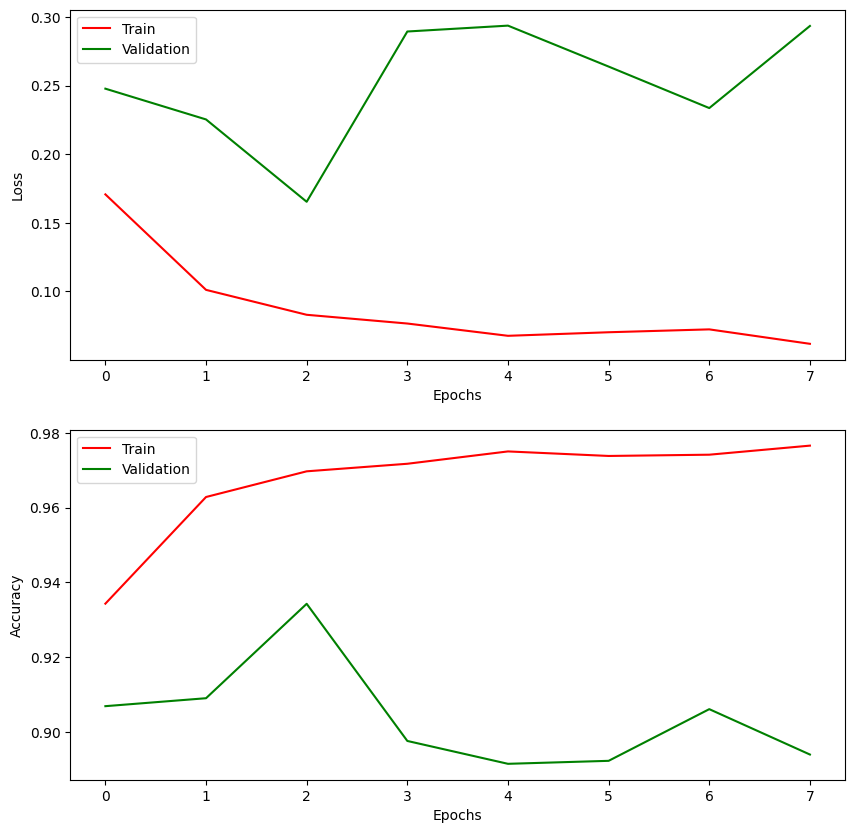

In [19]:
alplot(efficientnet)

In [20]:
encrtrain, encrval, encrtest = crep(ENmodel)

401/401 [==============================] - 44s 109ms/step
Training Classification Report:
              precision    recall  f1-score   support

           0       0.42      0.43      0.42     12235
           1       0.59      0.58      0.58     17457

    accuracy                           0.52     29692
   macro avg       0.50      0.50      0.50     29692
weighted avg       0.52      0.52      0.52     29692


Testing Classification Report:
              precision    recall  f1-score   support

           0       0.35      0.40      0.37      4418
           1       0.66      0.61      0.63      8405

    accuracy                           0.54     12823
   macro avg       0.50      0.50      0.50     12823
weighted avg       0.55      0.54      0.54     12823


Validation Classification Report:
              precision    recall  f1-score   support

           0       0.69      0.66      0.67      7654
           1       0.34      0.36      0.35      3632

    accuracy             

## ResNet50

In [21]:
RN = ResNet50(input_shape=(299, 299, 3), include_top=False, weights='imagenet')
RNmodel = transferlearn(RN)

94765736/94765736 [==============================] - 3s 0us/step


In [22]:
resnet = RNmodel.fit(
    augTrain,
    epochs=20,
    validation_data=tf_dataset_val,
    batch_size=8,
    callbacks=[earlyStopping]
)

Epoch 1/20
928/928 [==============================] - 178s 186ms/step - loss: 0.1055 - accuracy: 0.9620 - val_loss: 0.3176 - val_accuracy: 0.8769
Epoch 2/20
928/928 [==============================] - 173s 186ms/step - loss: 0.0460 - accuracy: 0.9838 - val_loss: 0.6421 - val_accuracy: 0.8320
Epoch 3/20
928/928 [==============================] - 174s 187ms/step - loss: 0.0390 - accuracy: 0.9862 - val_loss: 0.3375 - val_accuracy: 0.8773
Epoch 4/20
928/928 [==============================] - 174s 187ms/step - loss: 0.0384 - accuracy: 0.9862 - val_loss: 0.3760 - val_accuracy: 0.8772
Epoch 5/20
928/928 [==============================] - 172s 185ms/step - loss: 0.0317 - accuracy: 0.9893 - val_loss: 0.2289 - val_accuracy: 0.9139
Epoch 6/20
928/928 [==============================] - 172s 185ms/step - loss: 0.0276 - accuracy: 0.9902 - val_loss: 0.2180 - val_accuracy: 0.9167
Epoch 7/20
928/928 [==============================] - 173s 186ms/step - loss: 0.0268 - accuracy: 0.9906 - val_loss: 0.3445 -

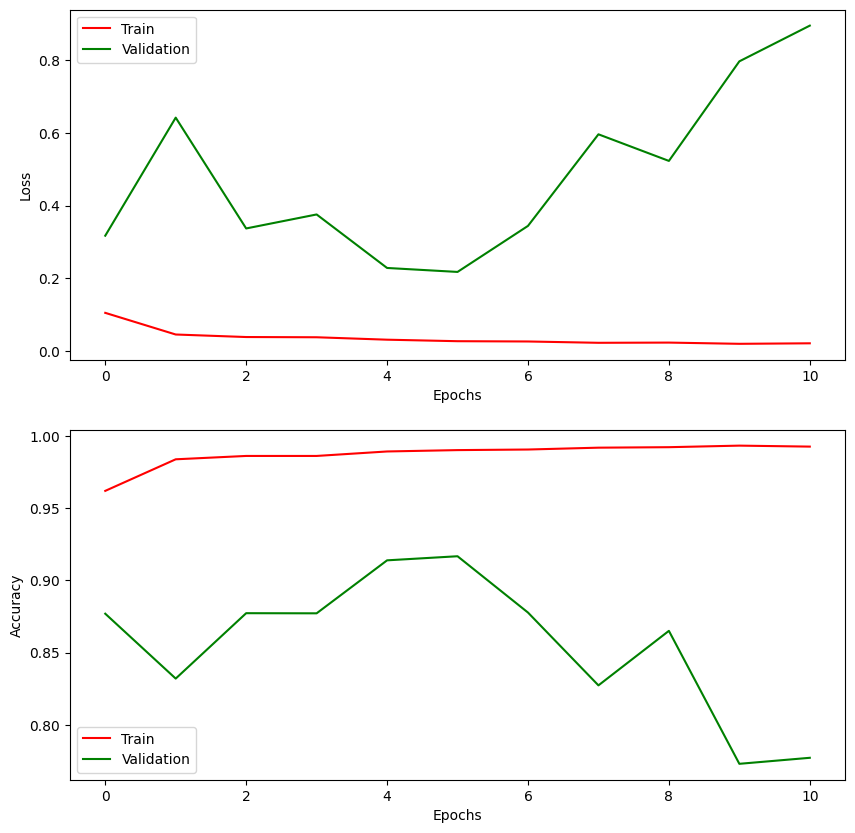

In [23]:
alplot(resnet)

In [24]:
rncrtrain, rncrval, rncrtest = crep(RNmodel)

401/401 [==============================] - 51s 126ms/step
Training Classification Report:
              precision    recall  f1-score   support

           0       0.41      0.42      0.42     12235
           1       0.59      0.58      0.59     17457

    accuracy                           0.52     29692
   macro avg       0.50      0.50      0.50     29692
weighted avg       0.52      0.52      0.52     29692


Testing Classification Report:
              precision    recall  f1-score   support

           0       0.35      0.33      0.34      4418
           1       0.66      0.67      0.67      8405

    accuracy                           0.56     12823
   macro avg       0.50      0.50      0.50     12823
weighted avg       0.55      0.56      0.55     12823


Validation Classification Report:
              precision    recall  f1-score   support

           0       0.68      0.61      0.64      7654
           1       0.33      0.41      0.37      3632

    accuracy             

## VGG16

In [25]:
VGG = VGG16(input_shape=(299, 299, 3), include_top=False, weights='imagenet')
VGGmodel = transferlearn(VGG)

58889256/58889256 [==============================] - 2s 0us/step


In [26]:
vgg16 = VGGmodel.fit(
    augTrain,
    epochs=20,
    validation_data=tf_dataset_val,
    batch_size=8,
    callbacks=[earlyStopping]
)

Epoch 1/20
928/928 [==============================] - 199s 211ms/step - loss: 0.1433 - accuracy: 0.9454 - val_loss: 0.4779 - val_accuracy: 0.8128
Epoch 2/20
928/928 [==============================] - 194s 208ms/step - loss: 0.0873 - accuracy: 0.9678 - val_loss: 0.4201 - val_accuracy: 0.8326
Epoch 3/20
928/928 [==============================] - 193s 208ms/step - loss: 0.0725 - accuracy: 0.9741 - val_loss: 0.6597 - val_accuracy: 0.7741
Epoch 4/20
928/928 [==============================] - 193s 208ms/step - loss: 0.0635 - accuracy: 0.9767 - val_loss: 0.5959 - val_accuracy: 0.8193
Epoch 5/20
928/928 [==============================] - 193s 208ms/step - loss: 0.0563 - accuracy: 0.9799 - val_loss: 0.7532 - val_accuracy: 0.7780
Epoch 6/20
928/928 [==============================] - 192s 207ms/step - loss: 0.0502 - accuracy: 0.9828 - val_loss: 0.4987 - val_accuracy: 0.8395
Epoch 7/20
928/928 [==============================] - 194s 208ms/step - loss: 0.0468 - accuracy: 0.9834 - val_loss: 0.5244 -

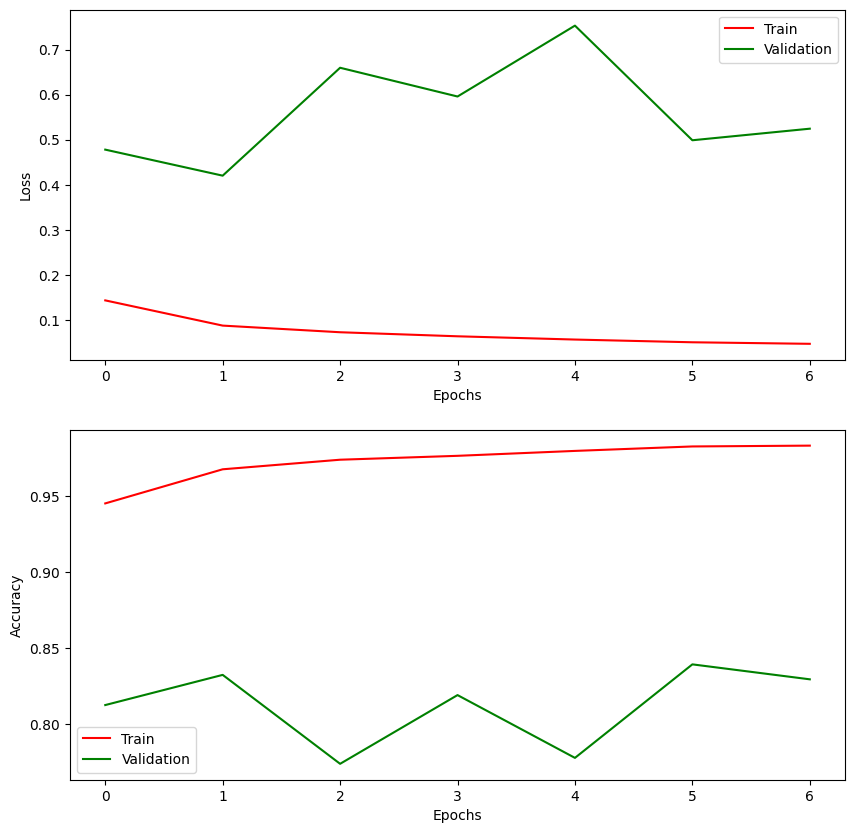

In [27]:
alplot(vgg16)

In [28]:
vggcrtrain, vggcrval, vggcrtest = crep(VGGmodel)

401/401 [==============================] - 59s 148ms/step
Training Classification Report:
              precision    recall  f1-score   support

           0       0.41      0.41      0.41     12235
           1       0.59      0.59      0.59     17457

    accuracy                           0.52     29692
   macro avg       0.50      0.50      0.50     29692
weighted avg       0.52      0.52      0.52     29692


Testing Classification Report:
              precision    recall  f1-score   support

           0       0.35      0.34      0.35      4418
           1       0.66      0.66      0.66      8405

    accuracy                           0.55     12823
   macro avg       0.50      0.50      0.50     12823
weighted avg       0.55      0.55      0.55     12823


Validation Classification Report:
              precision    recall  f1-score   support

           0       0.68      0.54      0.60      7654
           1       0.33      0.48      0.39      3632

    accuracy             

vi. Compare the results of transfer learning with that of CNN + MLP model and explain them.

In [29]:
#Training

print('For CNN+MLP model:')
print(cmcrtrain)

print('\nFor EfficientNetB0 model:')
print(encrtrain)

print('\nFor ResNet50 model:')
print(rncrtrain)

print('\nFor VGG16 model:')
print(vggcrtrain)

For CNN+MLP model:
              precision    recall  f1-score   support

           0       0.42      0.40      0.41     12235
           1       0.59      0.61      0.60     17457

    accuracy                           0.52     29692
   macro avg       0.50      0.50      0.50     29692
weighted avg       0.52      0.52      0.52     29692


For EfficientNetB0 model:
              precision    recall  f1-score   support

           0       0.42      0.43      0.42     12235
           1       0.59      0.58      0.58     17457

    accuracy                           0.52     29692
   macro avg       0.50      0.50      0.50     29692
weighted avg       0.52      0.52      0.52     29692


For ResNet50 model:
              precision    recall  f1-score   support

           0       0.41      0.42      0.42     12235
           1       0.59      0.58      0.59     17457

    accuracy                           0.52     29692
   macro avg       0.50      0.50      0.50     29692
weighte

In [30]:
#Testing

print('For CNN+MLP model:')
print(cmcrtest)

print('\nFor EfficientNetB0 model:')
print(encrtest)

print('\nFor ResNet50 model:')
print(rncrtest)

print('\nFor VGG16 model:')
print(vggcrtest)

For CNN+MLP model:
              precision    recall  f1-score   support

           0       0.69      0.57      0.62      7654
           1       0.33      0.45      0.38      3632

    accuracy                           0.53     11286
   macro avg       0.51      0.51      0.50     11286
weighted avg       0.57      0.53      0.55     11286


For EfficientNetB0 model:
              precision    recall  f1-score   support

           0       0.69      0.66      0.67      7654
           1       0.34      0.36      0.35      3632

    accuracy                           0.56     11286
   macro avg       0.51      0.51      0.51     11286
weighted avg       0.57      0.56      0.57     11286


For ResNet50 model:
              precision    recall  f1-score   support

           0       0.68      0.61      0.64      7654
           1       0.33      0.41      0.37      3632

    accuracy                           0.54     11286
   macro avg       0.51      0.51      0.50     11286
weighte

In [31]:
#Validation

print('For CNN+MLP model:')
print(cmcrval)

print('\nFor EfficientNetB0 model:')
print(encrval)

print('\nFor ResNet50 model:')
print(rncrval)

print('\nFor VGG16 model:')
print(vggcrval)

For CNN+MLP model:
              precision    recall  f1-score   support

           0       0.35      0.32      0.34      4418
           1       0.66      0.69      0.67      8405

    accuracy                           0.56     12823
   macro avg       0.51      0.51      0.50     12823
weighted avg       0.55      0.56      0.56     12823


For EfficientNetB0 model:
              precision    recall  f1-score   support

           0       0.35      0.40      0.37      4418
           1       0.66      0.61      0.63      8405

    accuracy                           0.54     12823
   macro avg       0.50      0.50      0.50     12823
weighted avg       0.55      0.54      0.54     12823


For ResNet50 model:
              precision    recall  f1-score   support

           0       0.35      0.33      0.34      4418
           1       0.66      0.67      0.67      8405

    accuracy                           0.56     12823
   macro avg       0.50      0.50      0.50     12823
weighte

# Final Observations
The overall observation shows that the accuracy is in the range of 52% to 56%.
When comparing CNN-MLP to the transfer learning models, they have **similar accuracy**.
(*CNN-MLP (56%) has higher testing accuracy than EfficientNetB0 (54%) and VGG16 (55%) though has similar testing accuracy to ResNet50 (56%).*)

In terms of **Precision, Recall and F-1 Score**,
CNN-MLP has a higher precision and recall for Class 1 whereas for the Transfer Learning models, the values are more balanced. Thus,

*   CNN-MLP might be preferred in cases where minimizing false positives for Class 1 is crucial.

*   EfficientNetB0, ResNet50, and VGG16 might be preferred in cases where balanced performance across both classes is more important.




